In [1]:
import rdkit.Chem.AllChem as rdkit
from rdkit.Chem import AllChem
import stk
import os

from rdkit import Chem

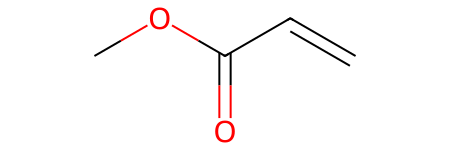

In [2]:
monomer_smiles = "COC(=O)C=C"

def create_monomer(smiles):
    """Parse SMILES and return RDKit molecule."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    return mol

monomer = create_monomer(monomer_smiles)
monomer = Chem.RWMol(monomer)
monomer

In [3]:
def replace_first_cce(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")

    acrylate_pattern = Chem.MolFromSmarts('C=C-C(=O)O')
    if not mol.HasSubstructMatch(acrylate_pattern):
        raise ValueError("No acrylate group (C=C-C(=O)O) found in the molecule")

    matches = mol.GetSubstructMatches(acrylate_pattern)
    match = matches[0]
    c1_idx, c2_idx = match[0], match[1]

    bond = mol.GetBondBetweenAtoms(c1_idx, c2_idx)
    if bond is None or bond.GetBondType() != Chem.BondType.DOUBLE:
        raise ValueError("Expected double bond not found in acrylate group")

    rw_mol = Chem.RWMol(mol)
    bond.SetBondType(Chem.BondType.SINGLE)

    br1 = rw_mol.AddAtom(Chem.Atom('Br'))
    br2 = rw_mol.AddAtom(Chem.Atom('Br'))
    rw_mol.AddBond(c1_idx, br1, Chem.BondType.SINGLE)
    rw_mol.AddBond(c2_idx, br2, Chem.BondType.SINGLE)

    Chem.SanitizeMol(rw_mol)

    return Chem.MolToSmiles(rw_mol, isomericSmiles=True)

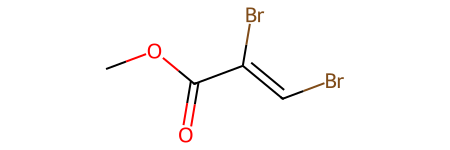

In [4]:
fixed_monomer_1 = monomer_smiles
fixed_monomer_2 = monomer_smiles

# Fix the fixed monomers smiles to bromo form
fixed1_bromo = replace_first_cce(fixed_monomer_1)
fixed2_bromo = replace_first_cce(fixed_monomer_2)
mB = Chem.MolFromSmiles(fixed2_bromo)
mB

In [5]:
bb1 = stk.BuildingBlock(fixed1_bromo, [stk.BromoFactory()])
bb2 = stk.BuildingBlock(fixed2_bromo, [stk.BromoFactory()])

# Construct the polymer
polymer = stk.ConstructedMolecule(
    topology_graph=stk.polymer.Linear(
        building_blocks=(bb1, bb2),
        repeating_unit='AB',
        num_repeating_units=8,
        optimizer=stk.Collapser(scale_steps=False),
    ),
)

# Convert to RDKit molecule
rdkit_polymer = polymer.to_rdkit_mol()
rdkit_polymer = Chem.AddHs(rdkit_polymer)
Chem.SanitizeMol(rdkit_polymer)

# Remove bromine atoms explicitly
rw_mol = Chem.RWMol(rdkit_polymer)
bromine_atoms = [atom.GetIdx() for atom in rw_mol.GetAtoms() if atom.GetSymbol() == 'Br']
for idx in sorted(bromine_atoms, reverse=True):  # Reverse to avoid index shifting
    rw_mol.RemoveAtom(idx)

# Update the RDKit molecule
rdkit_polymer = rw_mol.GetMol()
Chem.SanitizeMol(rdkit_polymer)

# Optimize the molecule
AllChem.MMFFOptimizeMolecule(rdkit_polymer)

# Update the STK polymer with new coordinates
polymer = polymer.with_position_matrix(
    position_matrix=rdkit_polymer.GetConformer().GetPositions()
)

def write_xyz_file(mol, filename):
    conf = mol.GetConformer()
    num_atoms = mol.GetNumAtoms()
    with open(filename, 'w') as f:
        f.write(f"{num_atoms}\n")
        f.write(f"Molecule ID: {os.path.basename(filename).split('.')[0]}\n")
        for i in range(num_atoms):
            atom = mol.GetAtomWithIdx(i)
            pos = conf.GetAtomPosition(i)
            symbol = atom.GetSymbol()
            f.write(f"{symbol} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}\n")

# Write XYZ file
xyz_filename = os.path.join('.', '2.xyz')
write_xyz_file(rdkit_polymer, xyz_filename)
print(f"Saved copolymer: {xyz_filename}")

Saved copolymer: ./2.xyz
